# 第九章-逻辑回归

## 9-1 什么是逻辑回归

逻辑回归: 解决分类问题  
问题: 回归问题怎么解决分类问题?  
将样本的特征和样本发生的概率联系起来, 概率是一个数(所以可以称为回归问题)

$\hat{y} = f(x)$  
$\hat{p} = f(x)$  
$ \hat{y} = \begin{cases} 1, & \text\{\hat{p} \geq 0.5\} \\ 0, & \text\{\hat{p} \leq 1\} \end{cases} $  
逻辑回归既可以看做是回归算法, 也可以看做是分类算法, 通常作为分类算法用, 只可以解决二分类问题.

$\hat{y} = f(x) \Longrightarrow \hat{y} = \theta^{T}.x_{b}$   
$\hat{p} = \sigma(\theta^{T}.x_{b})$  
$\sigma(t) = \frac{1}{1 + e^{-t}}$

`Sigmoid` 函数

In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
def sigmoid(t):
    return 1 / (1 + np.exp(-t))

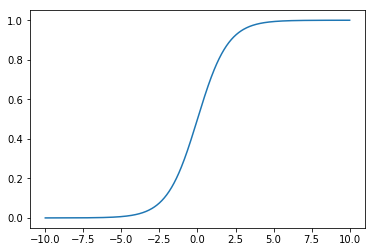

In [9]:
x = np.linspace(-10, 10, 500)
y = sigmoid(x)
plt.plot(x, y)
plt.show()

$\sigma(t) = \frac{1}{1 + e^{-1}}$  
值域(0, 1)  
t > 0 时, p > 0.5  
t < 0 时, p < 0.5

$\hat{p} = \sigma(\theta^{T}.x_{b}) = \frac{1}{1 + e^{-\theta^{T}.x_{b}}}$

问题: 对于给定的样本数据集 X, y, 我们如何找到参数 $\theta$, 使得用这样的方式, 可以最大程度获得样本数据集X对应的分类输出y ?

## 9-2 逻辑回归的损失函数

![](picture/9-2-1.png)

![](picture/9-2-2.png)

$$cost = -y\log(\hat{p}) - (1 - y)\log(1-\hat{p})$$

$$J(\theta) = -\frac{1}{m}\sum^{m}_{i=1}y^{(i)}\log(\hat{p}^{(i)}) + (1 - y^{(i)})\log(1-\hat{p}^{(i)})$$

$$\hat{p}^{(i)} = \sigma(X_{b}^{(i)}\theta) = \frac{1}{1 + e^{-X_{b}^{(i)}\theta}}$$

得到最终的损失函数(没有公式解, 只能使用梯度下降法求解): 
$$J(\theta) = -\frac{1}{m}\sum^{m}_{i=1}y^{(i)}\log(\sigma(X_{b}^{(i)}\theta)) + (1 - y^{(i)})\log(1-\sigma(X_{b}^{(i)}\theta))$$

## 9-3 逻辑回归损失函数的梯度

得到最终的损失函数(没有公式解, 只能使用梯度下降法求解): 
$$J(\theta) = -\frac{1}{m}\sum^{m}_{i=1}y^{(i)}\log(\sigma(X_{b}^{(i)}\theta)) + (1 - y^{(i)})\log(1-\sigma(X_{b}^{(i)}\theta))$$

损失函数的梯度:

![](picture/9-3-1.png)

## 9-4 实现逻辑回归算法

In [26]:
class LogisticRegression:

    def __init__(self):
        """初始化Logistic Regression模型"""
        self.coef_ = None
        self.intercept_ = None
        self._theta = None

    def _sigmoid(self, t):
        return 1. / (1. + np.exp(-t))

    def fit(self, X_train, y_train, eta=0.01, n_iters=1e4):
        """根据训练数据集X_train, y_train, 使用梯度下降法训练Logistic Regression模型"""
        assert X_train.shape[0] == y_train.shape[0], \
            "the size of X_train must be equal to the size of y_train"

        def J(theta, X_b, y):
            y_hat = self._sigmoid(X_b.dot(theta))
            try:
                return - np.sum(y*np.log(y_hat) + (1-y)*np.log(1-y_hat)) / len(y)
            except:
                return float('inf')

        def dJ(theta, X_b, y):
            return X_b.T.dot(self._sigmoid(X_b.dot(theta)) - y) / len(y)

        def gradient_descent(X_b, y, initial_theta, eta, n_iters=1e4, epsilon=1e-8):

            theta = initial_theta
            cur_iter = 0

            while cur_iter < n_iters:
                gradient = dJ(theta, X_b, y)
                last_theta = theta
                theta = theta - eta * gradient
                if (abs(J(theta, X_b, y) - J(last_theta, X_b, y)) < epsilon):
                    break

                cur_iter += 1

            return theta

        X_b = np.hstack([np.ones((len(X_train), 1)), X_train])
        initial_theta = np.zeros(X_b.shape[1])
        self._theta = gradient_descent(X_b, y_train, initial_theta, eta, n_iters)

        self.intercept_ = self._theta[0]
        self.coef_ = self._theta[1:]

        return self

    def predict_proba(self, X_predict):
        """给定待预测数据集X_predict，返回表示X_predict的结果概率向量"""
        assert self.intercept_ is not None and self.coef_ is not None, \
            "must fit before predict!"
        assert X_predict.shape[1] == len(self.coef_), \
            "the feature number of X_predict must be equal to X_train"

        X_b = np.hstack([np.ones((len(X_predict), 1)), X_predict])
        return self._sigmoid(X_b.dot(self._theta))

    def predict(self, X_predict):
        """给定待预测数据集X_predict，返回表示X_predict的结果向量"""
        assert self.intercept_ is not None and self.coef_ is not None, \
            "must fit before predict!"
        assert X_predict.shape[1] == len(self.coef_), \
            "the feature number of X_predict must be equal to X_train"

        proba = self.predict_proba(X_predict)
        return np.array(proba >= 0.5, dtype='int')

    def score(self, X_test, y_test):
        """根据测试数据集 X_test 和 y_test 确定当前模型的准确度"""

        y_predict = self.predict(X_test)
        return accuracy_score(y_test, y_predict)

    def __repr__(self):
        return "LogisticRegression()"

测试我们实现的逻辑回归算法

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

iris = datasets.load_iris()

In [30]:
X = iris.data
y = iris.target

In [31]:
X = X[y < 2, :2]
y = y[y < 2]

In [32]:
print(X.shape)
print(y.shape)

(100, 2)
(100,)


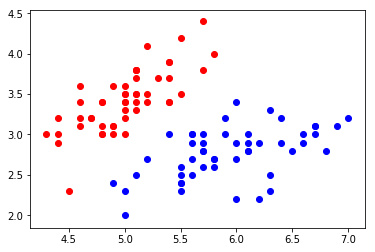

In [33]:
plt.scatter(X[y == 0, 0], X[y == 0, 1], color="r")
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue')
plt.show()

In [40]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
X_train, x_test, y_train, y_test = train_test_split(X, y, random_state=666)
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

In [42]:
log_reg.score(x_test, y_test)

1.0

In [44]:
log_reg.predict_proba(x_test)

array([0.93292947, 0.98717455, 0.15541379, 0.01786837, 0.03909442,
       0.01972689, 0.05214631, 0.99683149, 0.98092348, 0.75469962,
       0.0473811 , 0.00362352, 0.27122595, 0.03909442, 0.84902103,
       0.80627393, 0.83574223, 0.33477608, 0.06921637, 0.21582553,
       0.0240109 , 0.1836441 , 0.98092348, 0.98947619, 0.08342411])

In [47]:
log_reg.predict(x_test)

array([1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 0])

## 9-5 决策边界

## 9-6 在逻辑回归中使用多项式特征

## 9-7 `scikit-learn` 中的逻辑回归

## 9-8 `OvR` 与 `OvO`